### Initialize and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from numba import jit
import sys
sys.path.append(r'C:\Users\LHQS\Desktop\Austin\eHe Project\FEM\Channel Density (4-25)')
from dxfReader import DXFreader

alpha_ch = np.loadtxt('alpha_0.txt',skiprows=1)
alpha_lr = np.loadtxt('alpha_1.txt',skiprows=1)
alpha_rr = np.loadtxt('alpha_2.txt',skiprows=1)
alpha_gt = np.loadtxt('alpha_3.txt',skiprows=1)
alpha_gd = np.loadtxt('alpha_4.txt',skiprows=1)

x_vals = np.loadtxt('xlist.txt',skiprows=1)
y_vals = np.loadtxt('ylist.txt',skiprows=1)

x = np.reshape(x_vals,800)
y = np.reshape(y_vals,200)

plt.rc('font', size = 20)
plt.rcParams['axes.linewidth'] = 3 

### Plotting FEM Coupling Constants (alphas)

Layer           Num Obj
------------  ---------
electrodes B         36
dielectric            4


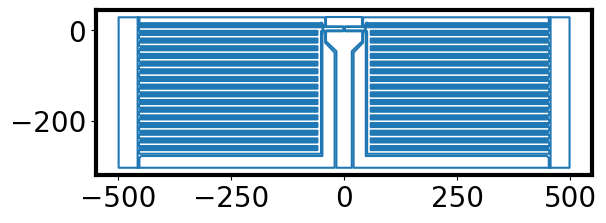

In [2]:
chip = DXFreader(r'C:\Users\LHQS\Desktop\Austin\eHe Project\FEM\Channel Density (4-25)\Step 1 mch_device 25a.dxf')
chip.plot_dxf();

#box_coords = [(-600, -300), (-600, 100), (600, 100), (600, -300)]
#chip.objects_in_box(box_coords)
#chip.plot_objects(['electrodes B'],['YELLOW'], ax=None, show_centroid=True)
#chip.plot_objects(['dielectric'], ['BLUE'], ax=None, show_centroid=True)

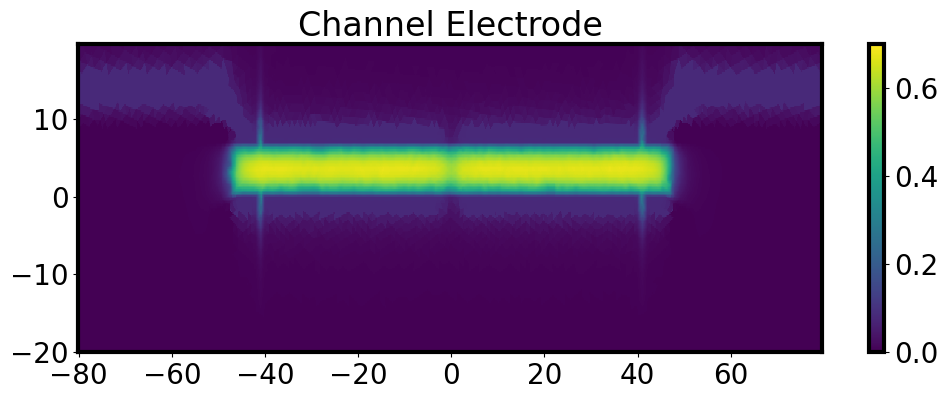

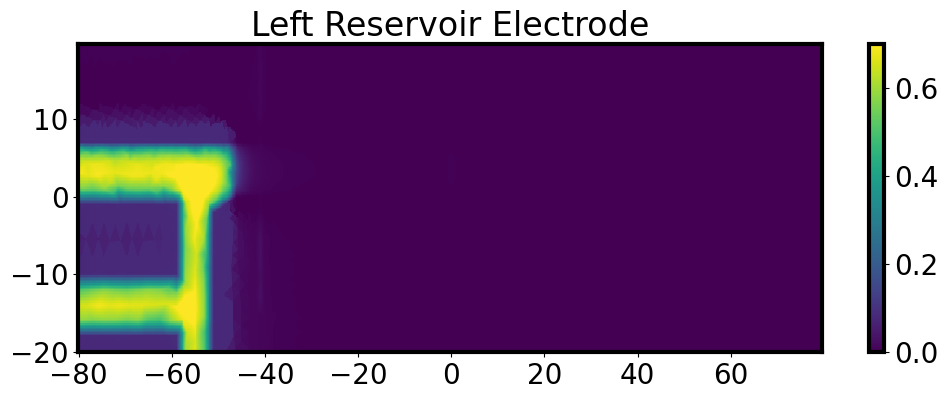

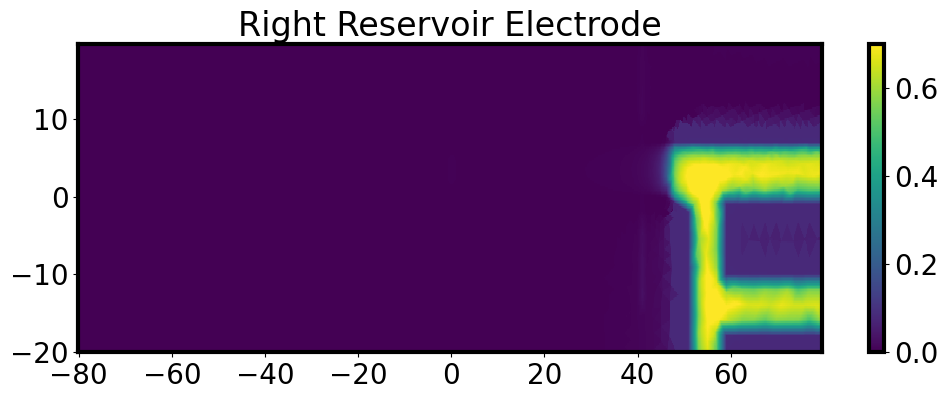

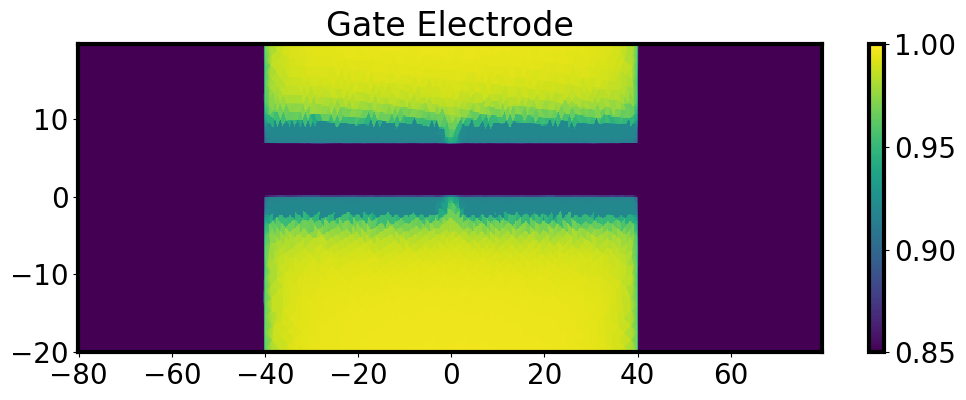

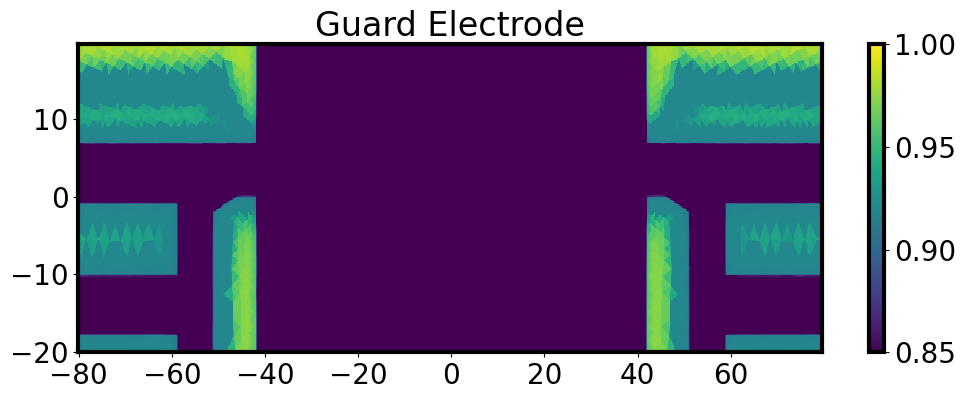

In [3]:
plt.figure(figsize=(12,4))
plt.pcolormesh(x,y,alpha_ch.T,shading='nearest',vmin=0, vmax=0.7);
plt.title('Channel Electrode')
plt.colorbar()
plt.show()

plt.figure(figsize=(12,4))
plt.pcolormesh(x,y,alpha_lr.T,shading='nearest',vmin=0, vmax=0.7);
plt.title('Left Reservoir Electrode')
plt.colorbar()
plt.show()

plt.figure(figsize=(12,4))
plt.pcolormesh(x,y,alpha_rr.T,shading='nearest',vmin=0, vmax=0.7);
plt.title('Right Reservoir Electrode')
plt.colorbar()
plt.show()

plt.figure(figsize=(12,4))
plt.pcolormesh(x,y,alpha_gt.T,shading='nearest',vmin=0.85, vmax=1);
plt.title('Gate Electrode')
plt.colorbar()
plt.show()

plt.figure(figsize=(12,4))
plt.pcolormesh(x,y,alpha_gd.T,shading='nearest',vmin=0.85,vmax=1);
plt.title('Guard Electrode')
plt.colorbar()
plt.show()

### FEM Slice Plotting

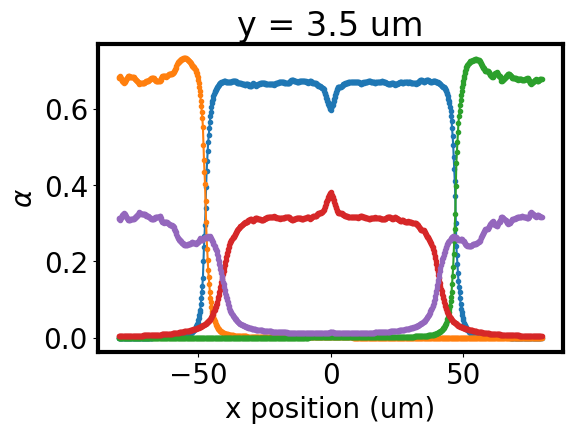

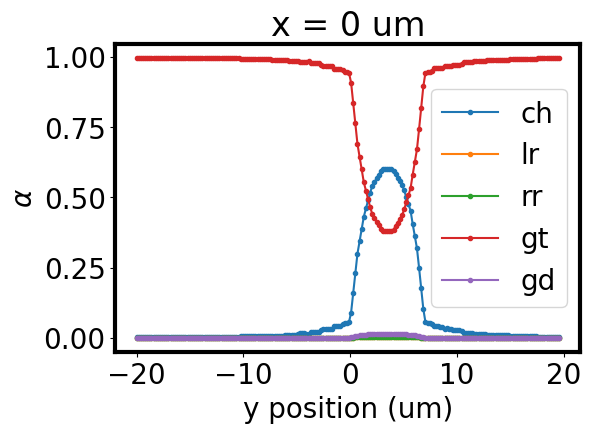

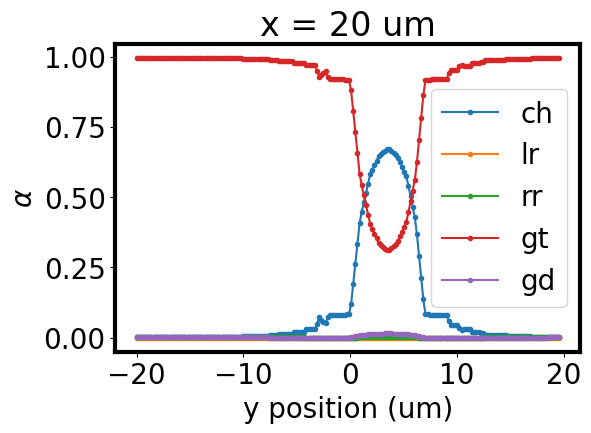

In [4]:
# Y=3.5um Slice

plt.figure(figsize=(6,4))
plt.plot(x,alpha_ch.T[118,:],'.-', label='ch')
plt.plot(x,alpha_lr.T[118,:],'.-', label='lr')
plt.plot(x,alpha_rr.T[118,:],'.-', label='rr')
plt.plot(x,alpha_gt.T[118,:],'.-', label='gt')
plt.plot(x,alpha_gd.T[118,:],'.-', label='gd')

plt.title('y = 3.5 um')
plt.xlabel('x position (um)')
plt.ylabel(r'$\alpha$')
plt.show()


# X= 0um Slice

plt.figure(figsize=(6,4))
plt.plot(y,alpha_ch.T[:,400],'.-', label='ch')
plt.plot(y,alpha_lr.T[:,400],'.-', label='lr')
plt.plot(y,alpha_rr.T[:,400],'.-', label='rr')
plt.plot(y,alpha_gt.T[:,400],'.-', label='gt')
plt.plot(y,alpha_gd.T[:,400],'.-', label='gd')

plt.title('x = 0 um')
plt.ylabel(r'$\alpha$')
plt.xlabel('y position (um)')
plt.legend()
plt.show()


# X= 20um Slice

plt.figure(figsize=(6,4))
plt.plot(y,alpha_ch.T[:,500],'.-', label='ch')
plt.plot(y,alpha_lr.T[:,500],'.-', label='lr')
plt.plot(y,alpha_rr.T[:,500],'.-', label='rr')
plt.plot(y,alpha_gt.T[:,500],'.-', label='gt')
plt.plot(y,alpha_gd.T[:,500],'.-', label='gd')

plt.title('x = 20 um')
plt.ylabel(r'$\alpha$')
plt.xlabel('y position (um)')
plt.legend()
plt.show()


### Density Code

Below is the code to calculate the effective width and the electron density as a function of the channel electrode bias voltage and the finite element modeling from above.

In [5]:
# Below I am using the Vchth, Vrs, and Vch values of dataset "P36" which corresponds to the 150 MHz 
# data.  However, the voltages used were not differed between different frequency datasets, so the
# channel bias dependent densities can be considered as general for our experiments. 

# Variables
Vchth = 0.65                     # channel threshold voltage from dataset
Vch   = np.linspace(0,2.4,101)   # channel voltage
Vgt   = 0                        # gate electrode bias
Vrs   = 0.6                      # reservoir electrode bias
midp  = 400                      # channel middle x index

# Constants 
eps   = 1.057                    # dielectric constant of liquid Helium
eps0  = 8.854e-12                # mks units
elec  = 1.602e-19                # Coulombs
d     = 1.38e-6                  # depth of Helium in meters

# Width Function ---------------------------------------------------------------------- #

@jit
def width(y,ylist):   # y position list, y-axis potential list, chemical potential
    lowcut  = 0
    highcut = 0
    phi_th  = np.min(-Vchth*alpha_ch[midp,:] - Vrs*(alpha_lr[midp,:]+alpha_rr[midp,:]))
    for i in range(len(ylist)-1):
        if   ylist[i] >= phi_th and ylist[i+1] <= phi_th:
            lowcut  = y[i]
        elif ylist[i] <= phi_th and ylist[i+1] >= phi_th:
            highcut = y[i]
    return highcut-lowcut

# Width Matrix ------------------------------------------------------------------------ #
   
we_matrix = np.zeros((len(Vch), len(x)))

for i in tqdm(range(len(Vch)), desc = 'Width Matrix', leave = False):
    phi    = Vch[i]*(alpha_ch.T) + Vrs*(alpha_lr.T + alpha_rr.T) + Vgt*(alpha_gt.T)
    phi_th = np.min(-Vchth*alpha_ch[midp,:] - Vrs*(alpha_lr[midp,:]+alpha_rr[midp,:]))
    for k in range(len(x)):
        we_temp = width(y,-phi[:,k])
        we_matrix[i,k] = we_temp

# Density Matrix ---------------------------------------------------------------------- #

ns_matrix = np.zeros((len(Vch),len(x),len(y)))

for i in tqdm(range(len(Vch)), desc ='Den Average Matrix', leave = False):
    phi    = Vch[i]*(alpha_ch) + Vrs*(alpha_lr + alpha_rr) + Vgt*(alpha_gt)
    phi_th = np.min(-Vchth*alpha_ch[midp,:] - Vrs*(alpha_lr[midp,:]+alpha_rr[midp,:]))
    for j in range(len(x)):
        for k in range(len(y)):
            if phi[j,k] + phi_th < 0:
                ns_matrix[i,j,k] = 0
            else:
                ns_matrix[i,j,k] = eps*eps0*(phi[j,k]+phi_th)/(elec*d)  

Width Matrix:   0%|          | 0/101 [00:00<?, ?it/s]

Den Average Matrix:   0%|          | 0/101 [00:00<?, ?it/s]

Text(0.5, 0, 'x position (um)')

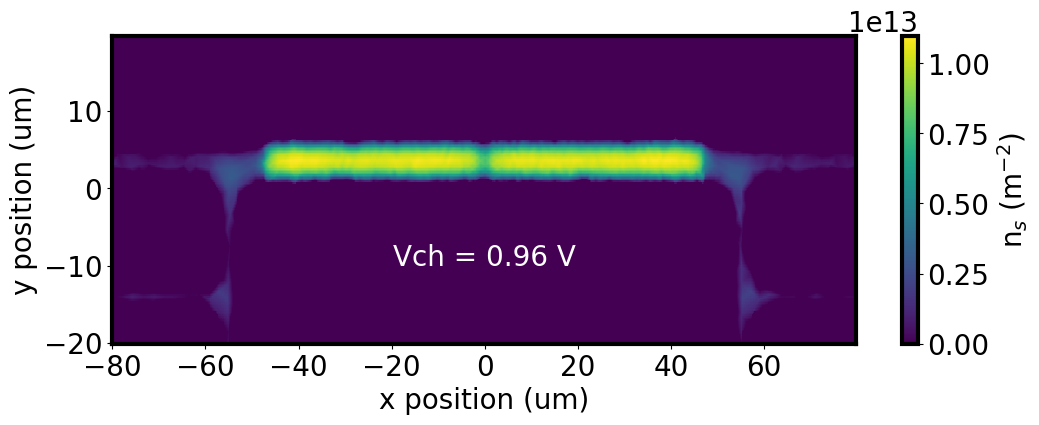

In [6]:
Vch_index = 40

plt.figure(figsize=(12,4))
plt.pcolormesh(x,y,ns_matrix[Vch_index,:,:].T)
plt.colorbar(label=r'n$_s$ (m$^{-2}$)')
plt.text(0,-10, f'Vch = {Vch[Vch_index]} V', color='white', ha='center', fontsize=20)
plt.ylabel('y position (um)')
plt.xlabel('x position (um)')

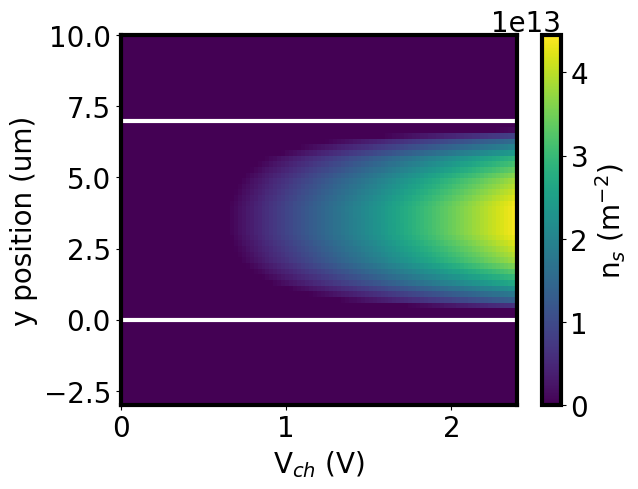

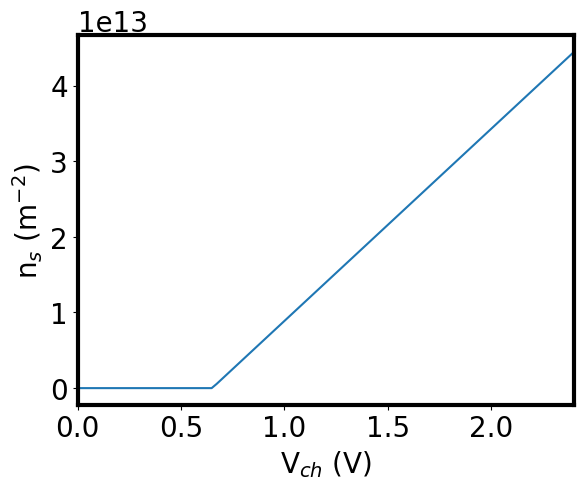

In [7]:
plt.pcolormesh(Vch,y,ns_matrix[:,400,:].T)
plt.colorbar(label=r'n$_s$ (m$^{-2}$)')
plt.hlines(0,-0.1,2.5,color='white',lw=3)
plt.hlines(7,-0.1,2.5,color='white',lw=3)
plt.ylabel('y position (um)')
plt.xlabel('V$_{ch}$ (V)')
plt.ylim(-3,10)
plt.xlim(0,2.4)
plt.show();

# Input
ns_mid_line = ns_matrix[:,400,118].T

plt.plot(Vch,ns_mid_line)
plt.ylabel(r'n$_s$ (m$^{-2}$)')
plt.xlabel('V$_{ch}$ (V)')
plt.xlim(0,2.4)
plt.show();